In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
train_path = "chest_xray/train"
test_path = "chest_xray/test"

In [4]:
IMAGE_SIZE = [128,128]

In [5]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(128,128),
                                              batch_size=2,
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(128,128),
                                            batch_size=2,
                                            class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [7]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=20,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)

In [9]:
from tensorflow.keras.applications import Xception, NASNetMobile

# Xception

In [10]:
# Defining the pretrained base model
base = Xception(include_top=False, weights='imagenet', input_shape=(128,128,3))
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(2, activation='softmax')(x)
# Combining base and head 
model5 = Model(inputs=base.input, outputs=head)

In [11]:
model5.compile(optimizer='sgd', 
              loss = 'categorical_crossentropy', 
              metrics=["accuracy",f1_m,precision_m, recall_m])
model5.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 16, 16, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)                                                                                        
                                                                                                  
 conv2d_2 (Conv2D)              (None, 8, 8, 728)    186368      ['add_1[0][0]']                  
                                                                                                  
 block4_po

                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 8, 8, 728)   2912        ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 8, 8, 728)   0           ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block7_sepconv2 (SeparableConv  (None, 8, 8, 728)   536536      ['block7_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_se

                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 8, 8, 728)   0           ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 8, 8, 728)   536536      ['block10_sepconv1_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block10_sepconv1_bn (BatchNorm  (None, 8, 8, 728)   2912        ['block10_sepconv1[0][0]']       
 alization)                                                                                       
          

 block12_sepconv3 (SeparableCon  (None, 8, 8, 728)   536536      ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 8, 8, 728)   2912        ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (Add)                   (None, 8, 8, 728)    0           ['block12_sepconv3_bn[0][0]',    
                                                                  'add_9[0][0]']                  
                                                                                                  
 block13_sepconv1_act (Activati  (None, 8, 8, 728)   0           ['add_10[0][0]']                 
 on)      

In [12]:
hist5 = model5.fit(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/50
2608/2608 [==============================] - 117s 44ms/step - loss: 0.2378 - accuracy: 0.9143 - f1_m: 0.9143 - precision_m: 0.9143 - recall_m: 0.9143 - val_loss: 24.5132 - val_accuracy: 0.7903 - val_f1_m: 0.7903 - val_precision_m: 0.7903 - val_recall_m: 0.7903 - lr: 0.0100
Epoch 2/50
2608/2608 [==============================] - 114s 44ms/step - loss: 0.1225 - accuracy: 0.9582 - f1_m: 0.9582 - precision_m: 0.9582 - recall_m: 0.9582 - val_loss: 0.1232 - val_accuracy: 0.9586 - val_f1_m: 0.9586 - val_precision_m: 0.9586 - val_recall_m: 0.9586 - lr: 0.0100
Epoch 3/50
2608/2608 [==============================] - 114s 44ms/step - loss: 0.0900 - accuracy: 0.9716 - f1_m: 0.9716 - precision_m: 0.9716 - recall_m: 0.9716 - val_loss: 0.1166 - val_accuracy: 0.9561 - val_f1_m: 0.9561 - val_precision_m: 0.9561 - val_recall_m: 0.9561 - lr: 0.0100
Epoch 4/50
2608/2608 [==============================] - 114s 44ms/step - loss: 0.0711 - accuracy: 0.9781 - f1_m: 0.9781 - precision_m: 0.9781 - rec

Epoch 27/50
2608/2608 [==============================] - 116s 45ms/step - loss: 0.0067 - accuracy: 0.9987 - f1_m: 0.9987 - precision_m: 0.9987 - recall_m: 0.9987 - val_loss: 0.0063 - val_accuracy: 0.9987 - val_f1_m: 0.9987 - val_precision_m: 0.9987 - val_recall_m: 0.9987 - lr: 8.1000e-05
Epoch 28/50
2608/2608 [==============================] - 113s 43ms/step - loss: 0.0072 - accuracy: 0.9987 - f1_m: 0.9987 - precision_m: 0.9987 - recall_m: 0.9987 - val_loss: 0.0095 - val_accuracy: 0.9975 - val_f1_m: 0.9975 - val_precision_m: 0.9975 - val_recall_m: 0.9975 - lr: 8.1000e-05
Epoch 29/50
2608/2608 [==============================] - 113s 44ms/step - loss: 0.0059 - accuracy: 0.9990 - f1_m: 0.9990 - precision_m: 0.9990 - recall_m: 0.9990 - val_loss: 0.0071 - val_accuracy: 0.9981 - val_f1_m: 0.9981 - val_precision_m: 0.9981 - val_recall_m: 0.9981 - lr: 8.1000e-05
Epoch 30/50
2607/2608 [============================>.] - ETA: 0s - loss: 0.0060 - accuracy: 0.9985 - f1_m: 0.9985 - precision_m: 0.99

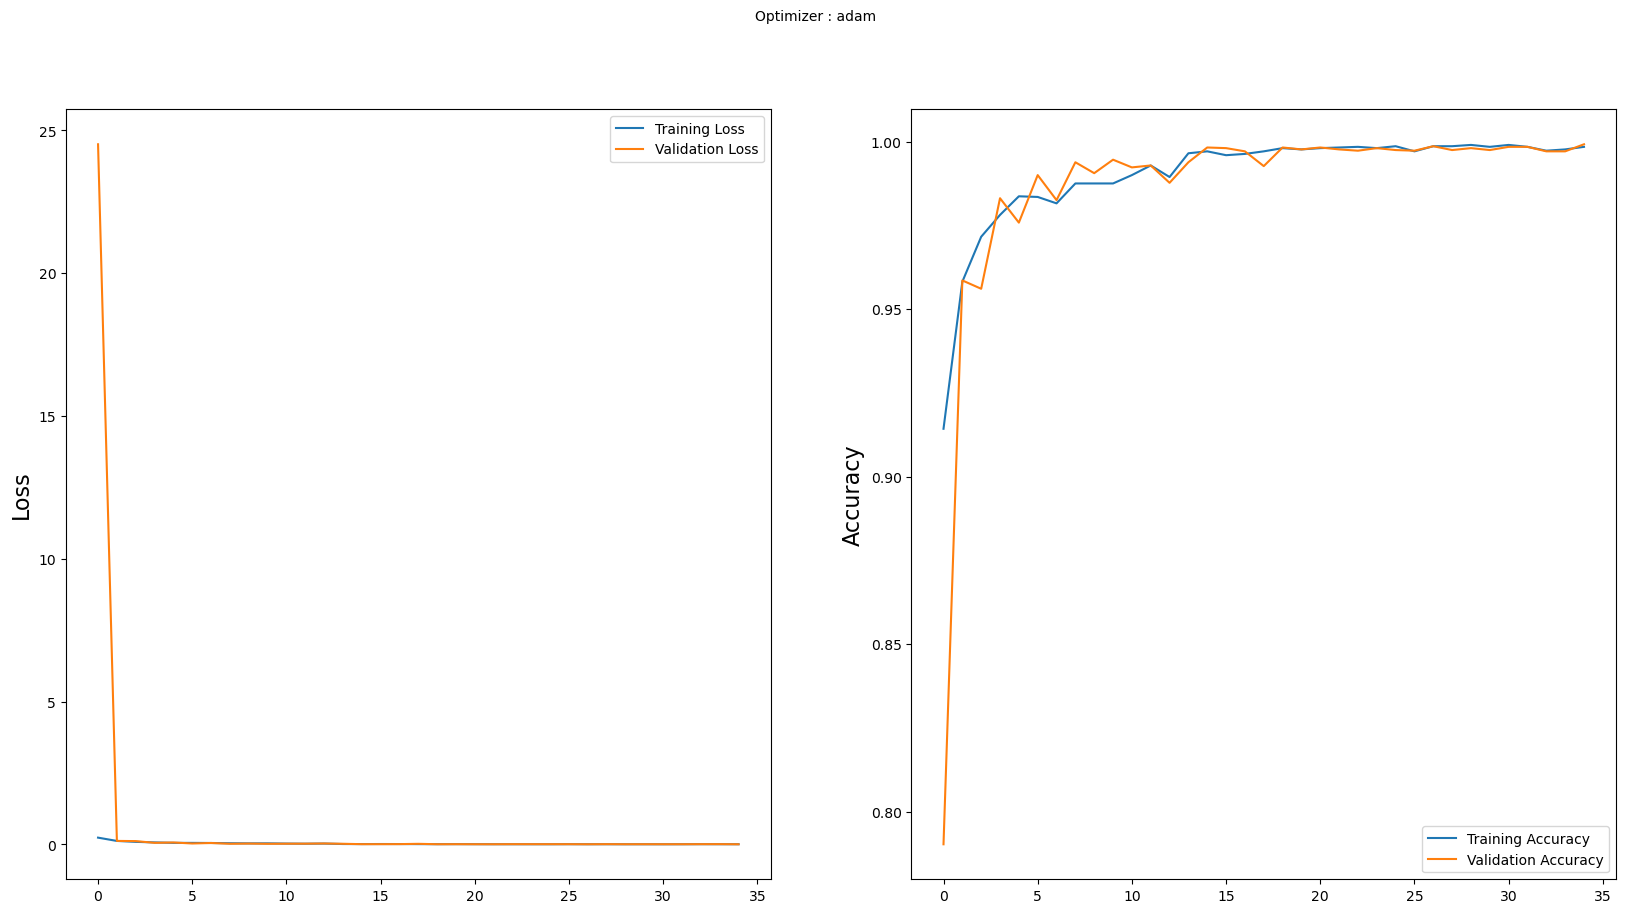

In [13]:
import matplotlib.pyplot as plt

x=hist5
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [14]:
model5.save('xception.h5')

# NaseNetMobile

In [15]:
# Defining the pretrained base model
base = NASNetMobile(include_top=False, weights='imagenet', input_shape=(128,128,3))
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(2, activation='softmax')(x)
# Combining base and head 
model6 = Model(inputs=base.input, outputs=head)

In [16]:
model6.compile(optimizer='sgd', 
              loss = 'categorical_crossentropy', 
              metrics=["accuracy",f1_m,precision_m, recall_m])
model6.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 63, 63, 32)   864         ['input_3[0][0]']                
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 63, 63, 32)   128         ['stem_conv1[0][0]']             
                                                                                                  
 activation (Activation)        (None, 63, 63, 32)   0           ['stem_bn1[0][0]']         

 right2_stem_1 (BatchNormalizat                                  t2_stem_1[0][0]']                
 ion)                                                                                             
                                                                                                  
 separable_conv_1_reduction_rig  (None, 32, 32, 11)  1152        ['separable_conv_1_pad_reduction_
 ht3_stem_1 (SeparableConv2D)                                    right3_stem_1[0][0]']            
                                                                                                  
 separable_conv_1_reduction_lef  (None, 32, 32, 11)  220         ['activation_9[0][0]']           
 t4_stem_1 (SeparableConv2D)                                                                      
                                                                                                  
 activation_6 (Activation)      (None, 32, 32, 11)   0           ['separable_conv_1_bn_reduction_r
          

                                                                                                  
 reduction_concat_stem_1 (Conca  (None, 32, 32, 44)  0           ['reduction_add_2_stem_1[0][0]', 
 tenate)                                                          'reduction_add3_stem_1[0][0]',  
                                                                  'add_12[0][0]',                 
                                                                  'reduction_add4_stem_1[0][0]']  
                                                                                                  
 adjust_avg_pool_1_stem_2 (Aver  (None, 32, 32, 32)  0           ['adjust_relu_1_stem_2[0][0]']   
 agePooling2D)                                                                                    
                                                                                                  
 adjust_avg_pool_2_stem_2 (Aver  (None, 32, 32, 32)  0           ['cropping2d[0][0]']             
 agePoolin

 reduction_add_1_stem_2 (Add)   (None, 16, 16, 22)   0           ['separable_conv_2_bn_reduction_l
                                                                 eft1_stem_2[0][0]',              
                                                                  'separable_conv_2_bn_reduction_r
                                                                 ight1_stem_2[0][0]']             
                                                                                                  
 separable_conv_1_reduction_rig  (None, 16, 16, 22)  1562        ['separable_conv_1_pad_reduction_
 ht2_stem_2 (SeparableConv2D)                                    right2_stem_2[0][0]']            
                                                                                                  
 separable_conv_1_pad_reduction  (None, 35, 35, 22)  0           ['activation_18[0][0]']          
 _right3_stem_2 (ZeroPadding2D)                                                                   
          

 D)                                                                                               
                                                                                                  
 reduction_add3_stem_2 (Add)    (None, 16, 16, 22)   0           ['reduction_left3_stem_2[0][0]', 
                                                                  'separable_conv_2_bn_reduction_r
                                                                 ight3_stem_2[0][0]']             
                                                                                                  
 add_13 (Add)                   (None, 16, 16, 22)   0           ['reduction_add_2_stem_2[0][0]', 
                                                                  'reduction_left4_stem_2[0][0]'] 
                                                                                                  
 reduction_add4_stem_2 (Add)    (None, 16, 16, 22)   0           ['separable_conv_2_bn_reduction_l
          

 activation_24 (Activation)     (None, 16, 16, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 1_0[0][0]']                      
                                                                                                  
 activation_26 (Activation)     (None, 16, 16, 44)   0           ['separable_conv_1_bn_normal_righ
                                                                 t1_0[0][0]']                     
                                                                                                  
 activation_28 (Activation)     (None, 16, 16, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 2_0[0][0]']                      
                                                                                                  
 activation_30 (Activation)     (None, 16, 16, 44)   0           ['separable_conv_1_bn_normal_righ
          

 activation_34 (Activation)     (None, 16, 16, 264)  0           ['normal_concat_0[0][0]']        
                                                                                                  
 adjust_conv_projection_1 (Conv  (None, 16, 16, 44)  3872        ['activation_33[0][0]']          
 2D)                                                                                              
                                                                                                  
 normal_conv_1_1 (Conv2D)       (None, 16, 16, 44)   11616       ['activation_34[0][0]']          
                                                                                                  
 adjust_bn_1 (BatchNormalizatio  (None, 16, 16, 44)  176         ['adjust_conv_projection_1[0][0]'
 n)                                                              ]                                
                                                                                                  
 normal_bn

 separable_conv_2_bn_normal_lef  (None, 16, 16, 44)  176         ['separable_conv_2_normal_left1_1
 t1_1 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 16, 16, 44)  176         ['separable_conv_2_normal_right1_
 ht1_1 (BatchNormalization)                                      1[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 16, 16, 44)  176         ['separable_conv_2_normal_left2_1
 t2_1 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 16, 16, 44)  176         ['separable_conv_2_normal_right2_
 ht2_1 (Ba

 2 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_1_normal_right2  (None, 16, 16, 44)  2332        ['activation_53[0][0]']          
 _2 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_left5_  (None, 16, 16, 44)  2332        ['activation_55[0][0]']          
 2 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 16, 16, 44)  176         ['separable_conv_1_normal_left1_2
 t1_2 (BatchNormalization)                                       [0][0]']                         
          

                                                                 2_2[0][0]',                      
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t2_2[0][0]']                     
                                                                                                  
 normal_add_3_2 (Add)           (None, 16, 16, 44)   0           ['normal_left3_2[0][0]',         
                                                                  'adjust_bn_2[0][0]']            
                                                                                                  
 normal_add_4_2 (Add)           (None, 16, 16, 44)   0           ['normal_left4_2[0][0]',         
                                                                  'normal_right4_2[0][0]']        
                                                                                                  
 normal_ad

                                                                 2_3[0][0]']                      
                                                                                                  
 activation_66 (Activation)     (None, 16, 16, 44)   0           ['separable_conv_1_bn_normal_righ
                                                                 t2_3[0][0]']                     
                                                                                                  
 activation_68 (Activation)     (None, 16, 16, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 5_3[0][0]']                      
                                                                                                  
 separable_conv_2_normal_left1_  (None, 16, 16, 44)  3036        ['activation_60[0][0]']          
 3 (SeparableConv2D)                                                                              
          

                                                                                                  
 reduction_bn_1_reduce_4 (Batch  (None, 16, 16, 88)  352         ['reduction_conv_1_reduce_4[0][0]
 Normalization)                                                  ']                               
                                                                                                  
 adjust_bn_reduce_4 (BatchNorma  (None, 16, 16, 88)  352         ['adjust_conv_projection_reduce_4
 lization)                                                       [0][0]']                         
                                                                                                  
 activation_71 (Activation)     (None, 16, 16, 88)   0           ['reduction_bn_1_reduce_4[0][0]']
                                                                                                  
 activation_73 (Activation)     (None, 16, 16, 88)   0           ['adjust_bn_reduce_4[0][0]']     
          

 separable_conv_1_reduction_lef  (None, 8, 8, 88)    8536        ['activation_79[0][0]']          
 t4_reduce_4 (SeparableConv2D)                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 8, 8, 88)     0           ['separable_conv_1_bn_reduction_r
                                                                 ight2_reduce_4[0][0]']           
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 8, 8, 88)    352         ['separable_conv_1_reduction_righ
 right3_reduce_4 (BatchNormaliz                                  t3_reduce_4[0][0]']              
 ation)                                                                                           
                                                                                                  
 separable

                                                                  'reduction_add4_reduce_4[0][0]']
                                                                                                  
 adjust_avg_pool_1_5 (AveragePo  (None, 8, 8, 264)   0           ['adjust_relu_1_5[0][0]']        
 oling2D)                                                                                         
                                                                                                  
 adjust_avg_pool_2_5 (AveragePo  (None, 8, 8, 264)   0           ['cropping2d_2[0][0]']           
 oling2D)                                                                                         
                                                                                                  
 adjust_conv_1_5 (Conv2D)       (None, 8, 8, 44)     11616       ['adjust_avg_pool_1_5[0][0]']    
                                                                                                  
 adjust_co

                                                                                                  
 separable_conv_2_normal_right1  (None, 8, 8, 88)    8536        ['activation_85[0][0]']          
 _5 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left2_  (None, 8, 8, 88)    9944        ['activation_87[0][0]']          
 5 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right2  (None, 8, 8, 88)    8536        ['activation_89[0][0]']          
 _5 (SeparableConv2D)                                                                             
                                                                                                  
 separable

                                                                                                  
 activation_98 (Activation)     (None, 8, 8, 88)     0           ['adjust_bn_6[0][0]']            
                                                                                                  
 activation_100 (Activation)    (None, 8, 8, 88)     0           ['adjust_bn_6[0][0]']            
                                                                                                  
 activation_102 (Activation)    (None, 8, 8, 88)     0           ['normal_bn_1_6[0][0]']          
                                                                                                  
 separable_conv_1_normal_left1_  (None, 8, 8, 88)    9944        ['activation_94[0][0]']          
 6 (SeparableConv2D)                                                                              
                                                                                                  
 separable

 2D)                                                                                              
                                                                                                  
 normal_right4_6 (AveragePoolin  (None, 8, 8, 88)    0           ['adjust_bn_6[0][0]']            
 g2D)                                                                                             
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 8, 8, 88)    352         ['separable_conv_2_normal_left5_6
 t5_6 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 normal_add_1_6 (Add)           (None, 8, 8, 88)     0           ['separable_conv_2_bn_normal_left
                                                                 1_6[0][0]',                      
          

                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 8, 8, 88)    352         ['separable_conv_1_normal_right2_
 ht2_7 (BatchNormalization)                                      7[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 8, 8, 88)    352         ['separable_conv_1_normal_left5_7
 t5_7 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 activation_107 (Activation)    (None, 8, 8, 88)     0           ['separable_conv_1_bn_normal_left
                                                                 1_7[0][0]']                      
                                                                                                  
 activatio

                                                                  'normal_add_2_7[0][0]',         
                                                                  'normal_add_3_7[0][0]',         
                                                                  'normal_add_4_7[0][0]',         
                                                                  'normal_add_5_7[0][0]']         
                                                                                                  
 activation_116 (Activation)    (None, 8, 8, 528)    0           ['normal_concat_6[0][0]']        
                                                                                                  
 activation_117 (Activation)    (None, 8, 8, 528)    0           ['normal_concat_7[0][0]']        
                                                                                                  
 adjust_conv_projection_8 (Conv  (None, 8, 8, 88)    46464       ['activation_116[0][0]']         
 2D)      

                                                                                                  
 separable_conv_2_normal_right2  (None, 8, 8, 88)    8536        ['activation_125[0][0]']         
 _8 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left5_  (None, 8, 8, 88)    8536        ['activation_127[0][0]']         
 8 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 8, 8, 88)    352         ['separable_conv_2_normal_left1_8
 t1_8 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable

 _right1_reduce_8 (ZeroPadding2                                                                   
 D)                                                                                               
                                                                                                  
 separable_conv_1_reduction_lef  (None, 4, 4, 176)   35376       ['separable_conv_1_pad_reduction_
 t1_reduce_8 (SeparableConv2D)                                   left1_reduce_8[0][0]']           
                                                                                                  
 separable_conv_1_reduction_rig  (None, 4, 4, 176)   39600       ['separable_conv_1_pad_reduction_
 ht1_reduce_8 (SeparableConv2D)                                  right1_reduce_8[0][0]']          
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 4, 4, 176)   704         ['separable_conv_1_reduction_left
 left1_red

                                                                                                  
 separable_conv_2_reduction_rig  (None, 4, 4, 176)   39600       ['activation_135[0][0]']         
 ht2_reduce_8 (SeparableConv2D)                                                                   
                                                                                                  
 activation_137 (Activation)    (None, 4, 4, 176)    0           ['separable_conv_1_bn_reduction_r
                                                                 ight3_reduce_8[0][0]']           
                                                                                                  
 activation_139 (Activation)    (None, 4, 4, 176)    0           ['separable_conv_1_bn_reduction_l
                                                                 eft4_reduce_8[0][0]']            
                                                                                                  
 reduction

                                                                  'adjust_conv_2_9[0][0]']        
                                                                                                  
 normal_conv_1_9 (Conv2D)       (None, 4, 4, 176)    123904      ['activation_140[0][0]']         
                                                                                                  
 adjust_bn_9 (BatchNormalizatio  (None, 4, 4, 176)   704         ['concatenate_3[0][0]']          
 n)                                                                                               
                                                                                                  
 normal_bn_1_9 (BatchNormalizat  (None, 4, 4, 176)   704         ['normal_conv_1_9[0][0]']        
 ion)                                                                                             
                                                                                                  
 activatio

 separable_conv_2_bn_normal_rig  (None, 4, 4, 176)   704         ['separable_conv_2_normal_right1_
 ht1_9 (BatchNormalization)                                      9[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 4, 4, 176)   704         ['separable_conv_2_normal_left2_9
 t2_9 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 4, 4, 176)   704         ['separable_conv_2_normal_right2_
 ht2_9 (BatchNormalization)                                      9[0][0]']                        
                                                                                                  
 normal_left3_9 (AveragePooling  (None, 4, 4, 176)   0           ['normal_bn_1_9[0][0]']          
 2D)      

 separable_conv_1_normal_right2  (None, 4, 4, 176)   32560       ['activation_159[0][0]']         
 _10 (SeparableConv2D)                                                                            
                                                                                                  
 separable_conv_1_normal_left5_  (None, 4, 4, 176)   32560       ['activation_161[0][0]']         
 10 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 4, 4, 176)   704         ['separable_conv_1_normal_left1_1
 t1_10 (BatchNormalization)                                      0[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 4, 4, 176)   704         ['separable_conv_1_normal_right1_
 ht1_10 (B

                                                                 t2_10[0][0]']                    
                                                                                                  
 normal_add_3_10 (Add)          (None, 4, 4, 176)    0           ['normal_left3_10[0][0]',        
                                                                  'adjust_bn_10[0][0]']           
                                                                                                  
 normal_add_4_10 (Add)          (None, 4, 4, 176)    0           ['normal_left4_10[0][0]',        
                                                                  'normal_right4_10[0][0]']       
                                                                                                  
 normal_add_5_10 (Add)          (None, 4, 4, 176)    0           ['separable_conv_2_bn_normal_left
                                                                 5_10[0][0]',                     
          

 activation_172 (Activation)    (None, 4, 4, 176)    0           ['separable_conv_1_bn_normal_righ
                                                                 t2_11[0][0]']                    
                                                                                                  
 activation_174 (Activation)    (None, 4, 4, 176)    0           ['separable_conv_1_bn_normal_left
                                                                 5_11[0][0]']                     
                                                                                                  
 separable_conv_2_normal_left1_  (None, 4, 4, 176)   35376       ['activation_166[0][0]']         
 11 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_right1  (None, 4, 4, 176)   32560       ['activation_168[0][0]']         
 _11 (Sepa

                                                                                                  
 normal_bn_1_12 (BatchNormaliza  (None, 4, 4, 176)   704         ['normal_conv_1_12[0][0]']       
 tion)                                                                                            
                                                                                                  
 activation_177 (Activation)    (None, 4, 4, 176)    0           ['normal_bn_1_12[0][0]']         
                                                                                                  
 activation_179 (Activation)    (None, 4, 4, 176)    0           ['adjust_bn_12[0][0]']           
                                                                                                  
 activation_181 (Activation)    (None, 4, 4, 176)    0           ['adjust_bn_12[0][0]']           
                                                                                                  
 activatio

 separable_conv_2_bn_normal_rig  (None, 4, 4, 176)   704         ['separable_conv_2_normal_right2_
 ht2_12 (BatchNormalization)                                     12[0][0]']                       
                                                                                                  
 normal_left3_12 (AveragePoolin  (None, 4, 4, 176)   0           ['normal_bn_1_12[0][0]']         
 g2D)                                                                                             
                                                                                                  
 normal_left4_12 (AveragePoolin  (None, 4, 4, 176)   0           ['adjust_bn_12[0][0]']           
 g2D)                                                                                             
                                                                                                  
 normal_right4_12 (AveragePooli  (None, 4, 4, 176)   0           ['adjust_bn_12[0][0]']           
 ng2D)    

In [17]:
hist6 = model6.fit(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/50
2608/2608 [==============================] - 412s 153ms/step - loss: 0.2481 - accuracy: 0.8947 - f1_m: 0.8947 - precision_m: 0.8947 - recall_m: 0.8947 - val_loss: 0.8365 - val_accuracy: 0.7473 - val_f1_m: 0.7473 - val_precision_m: 0.7473 - val_recall_m: 0.7473 - lr: 0.0100
Epoch 2/50
2608/2608 [==============================] - 397s 152ms/step - loss: 0.1071 - accuracy: 0.9615 - f1_m: 0.9615 - precision_m: 0.9615 - recall_m: 0.9615 - val_loss: 0.2338 - val_accuracy: 0.8798 - val_f1_m: 0.8798 - val_precision_m: 0.8798 - val_recall_m: 0.8798 - lr: 0.0100
Epoch 3/50
2608/2608 [==============================] - 397s 152ms/step - loss: 0.0893 - accuracy: 0.9686 - f1_m: 0.9686 - precision_m: 0.9686 - recall_m: 0.9686 - val_loss: 0.1199 - val_accuracy: 0.9682 - val_f1_m: 0.9682 - val_precision_m: 0.9682 - val_recall_m: 0.9682 - lr: 0.0100
Epoch 4/50
2608/2608 [==============================] - 397s 152ms/step - loss: 0.0696 - accuracy: 0.9770 - f1_m: 0.9770 - precision_m: 0.9770 - 

2608/2608 [==============================] - 396s 152ms/step - loss: 0.0112 - accuracy: 0.9956 - f1_m: 0.9956 - precision_m: 0.9956 - recall_m: 0.9956 - val_loss: 0.0692 - val_accuracy: 0.9703 - val_f1_m: 0.9703 - val_precision_m: 0.9703 - val_recall_m: 0.9703 - lr: 2.4300e-05
Epoch 26/50
2608/2608 [==============================] - 397s 152ms/step - loss: 0.0162 - accuracy: 0.9956 - f1_m: 0.9956 - precision_m: 0.9956 - recall_m: 0.9956 - val_loss: 0.0718 - val_accuracy: 0.9722 - val_f1_m: 0.9722 - val_precision_m: 0.9722 - val_recall_m: 0.9722 - lr: 7.2900e-06
Epoch 27/50
2608/2608 [==============================] - 396s 152ms/step - loss: 0.0119 - accuracy: 0.9954 - f1_m: 0.9954 - precision_m: 0.9954 - recall_m: 0.9954 - val_loss: 0.0694 - val_accuracy: 0.9714 - val_f1_m: 0.9714 - val_precision_m: 0.9714 - val_recall_m: 0.9714 - lr: 7.2900e-06
Epoch 27: early stopping


In [18]:
model6.save('nasnet.h5')

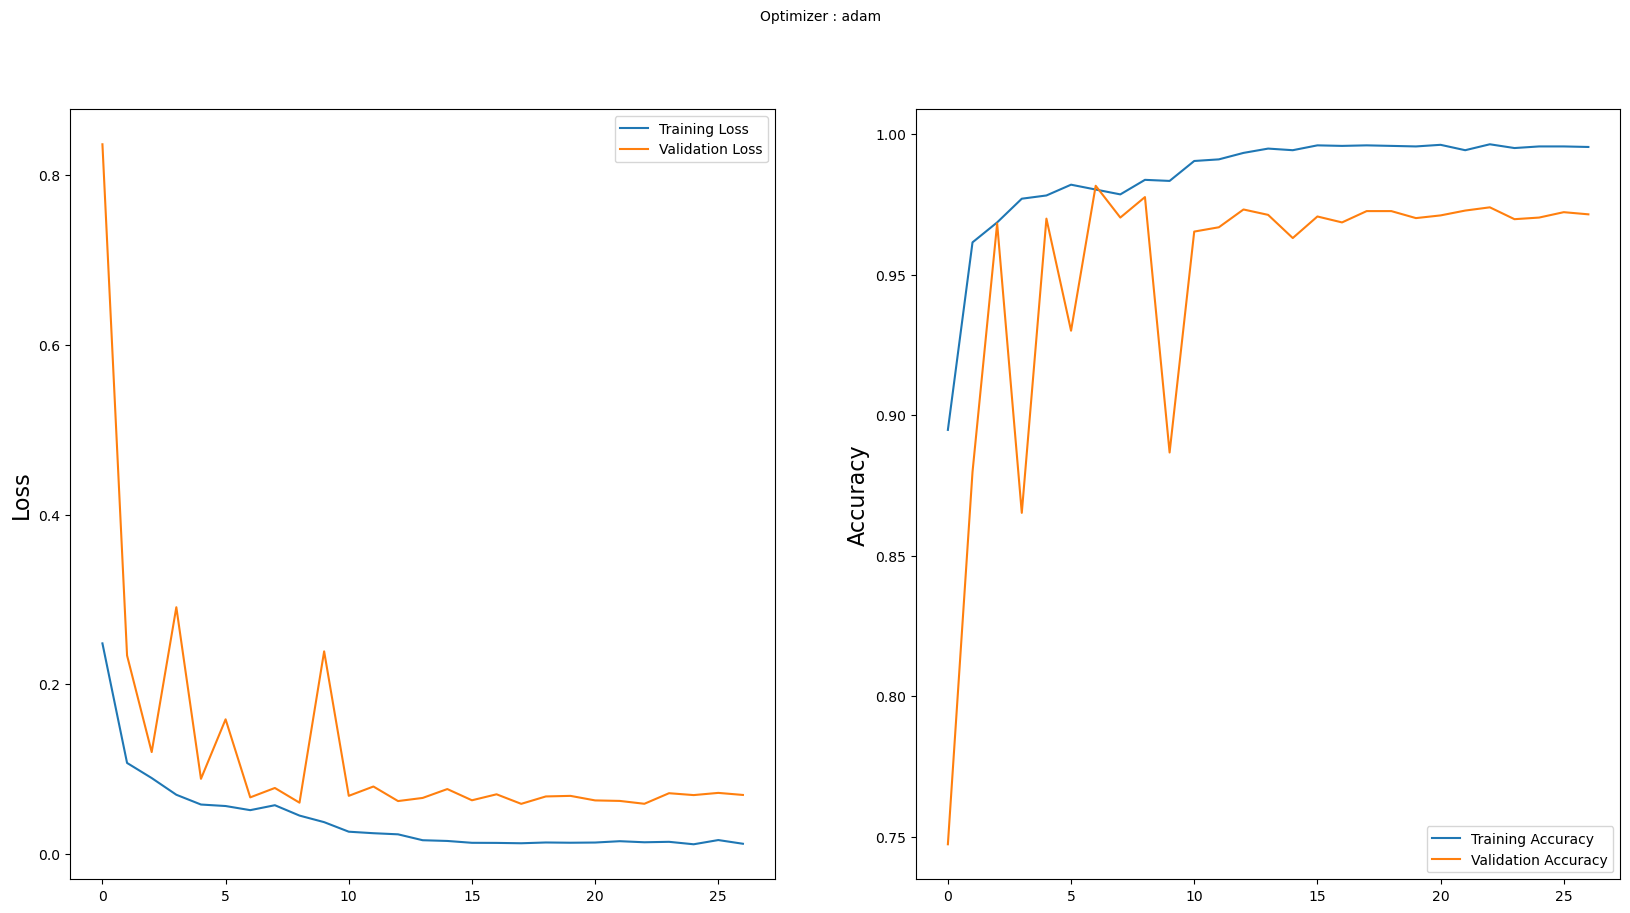

In [19]:
import matplotlib.pyplot as plt

x=hist6
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Ensemble

In [20]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Average
import efficientnet.keras 
def ensemble():

    model_1 = load_model('xception.h5', compile=False)
    model_1 = Model(inputs = model_1.inputs, outputs = model_1.outputs, name = 'Xception')

    model_2 = load_model('nasnet.h5', compile=False)
    model_2 = Model(inputs = model_2.inputs, outputs = model_2.outputs, name = 'NaseNet')
    
    models = [model_1, model_2]


    models_input = Input(shape =(128,128,3))
    models_output = [model(models_input) for model in models]
    
    ensemble_output = Average()(models_output)

    simple_average = Model(inputs = models_input, outputs = ensemble_output, name = 'Ensemble')

    return simple_average

In [21]:
ext = ensemble()
ext.compile(optimizer='sgd', 
              loss = 'categorical_crossentropy', 
              metrics=["accuracy",f1_m,precision_m, recall_m])
ext.summary()

Model: "Ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Xception (Functional)          (None, 2)            20865578    ['input_4[0][0]']                
                                                                                                  
 NaseNet (Functional)           (None, 2)            4271830     ['input_4[0][0]']                
                                                                                                  
 average_1 (Average)            (None, 2)            0           ['Xception[0][0]',        

In [22]:
history = ext.fit(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/50
2608/2608 [==============================] - 543s 202ms/step - loss: 0.0193 - accuracy: 0.9948 - f1_m: 0.9948 - precision_m: 0.9948 - recall_m: 0.9948 - val_loss: 0.0198 - val_accuracy: 0.9985 - val_f1_m: 0.9985 - val_precision_m: 0.9985 - val_recall_m: 0.9985 - lr: 0.0100
Epoch 2/50
2608/2608 [==============================] - 521s 200ms/step - loss: 0.0171 - accuracy: 0.9952 - f1_m: 0.9952 - precision_m: 0.9952 - recall_m: 0.9952 - val_loss: 0.0259 - val_accuracy: 0.9965 - val_f1_m: 0.9965 - val_precision_m: 0.9965 - val_recall_m: 0.9965 - lr: 0.0100
Epoch 3/50
2608/2608 [==============================] - 521s 200ms/step - loss: 0.0133 - accuracy: 0.9962 - f1_m: 0.9962 - precision_m: 0.9962 - recall_m: 0.9962 - val_loss: 0.0190 - val_accuracy: 0.9985 - val_f1_m: 0.9985 - val_precision_m: 0.9985 - val_recall_m: 0.9985 - lr: 0.0100
Epoch 4/50
2608/2608 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.9962 - f1_m: 0.9962 - precision_m: 0.9962 - recall_m

Epoch 26/50
2608/2608 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.9985 - f1_m: 0.9985 - precision_m: 0.9985 - recall_m: 0.9985
Epoch 26: ReduceLROnPlateau reducing learning rate to 7.289999848580919e-06.
2608/2608 [==============================] - 518s 198ms/step - loss: 0.0057 - accuracy: 0.9985 - f1_m: 0.9985 - precision_m: 0.9985 - recall_m: 0.9985 - val_loss: 0.0218 - val_accuracy: 0.9994 - val_f1_m: 0.9994 - val_precision_m: 0.9994 - val_recall_m: 0.9994 - lr: 2.4300e-05
Epoch 27/50
2608/2608 [==============================] - 520s 200ms/step - loss: 0.0069 - accuracy: 0.9988 - f1_m: 0.9988 - precision_m: 0.9988 - recall_m: 0.9988 - val_loss: 0.0211 - val_accuracy: 0.9990 - val_f1_m: 0.9990 - val_precision_m: 0.9990 - val_recall_m: 0.9990 - lr: 7.2900e-06
Epoch 28/50
2608/2608 [==============================] - 522s 200ms/step - loss: 0.0060 - accuracy: 0.9987 - f1_m: 0.9987 - precision_m: 0.9987 - recall_m: 0.9987 - val_loss: 0.0220 - val_accuracy: 0.

In [23]:
ext.save('ensemble.h5')

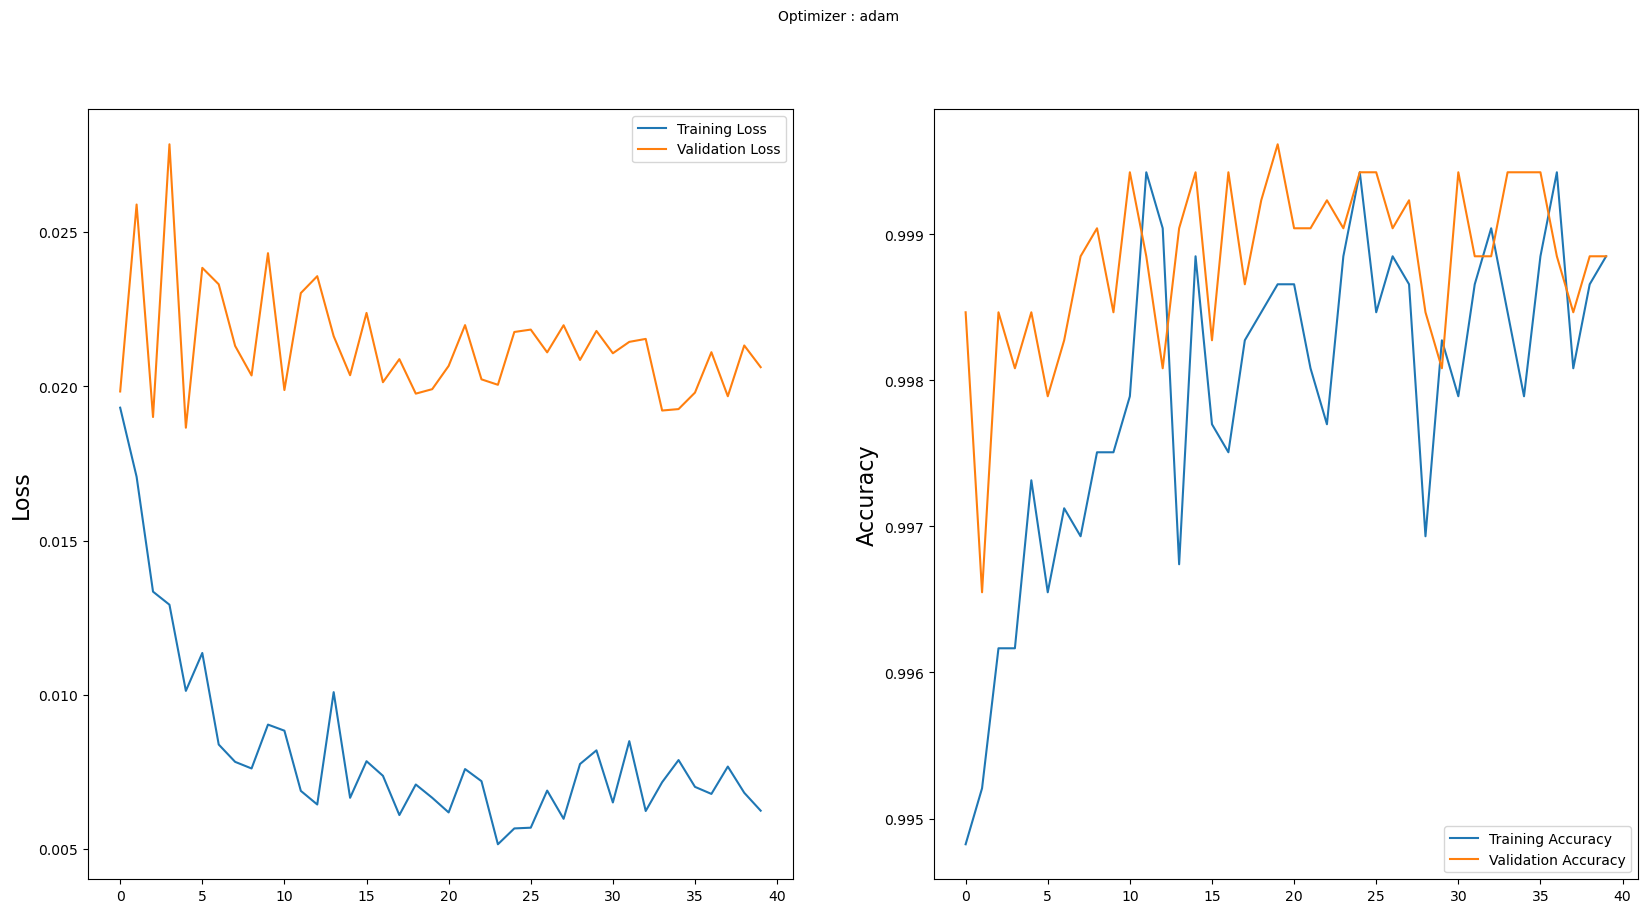

In [24]:
import matplotlib.pyplot as plt

x=history
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()